In [9]:
import requests
import os

# 下載字體文件
font_url = 'https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download'
font_path = 'TaipeiSansTCBeta-Regular.ttf'

response = requests.get(font_url)
with open(font_path, 'wb') as f:
    f.write(response.content)

print(f"Font downloaded successfully and saved as {font_path}")


Font downloaded successfully and saved as TaipeiSansTCBeta-Regular.ttf


### 第一步：爬取文章並存成 DataFrame 和 JSON 檔案

In [10]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import json

class ETTodayCrawler:
    def __init__(self, base_url):
        self.base_url = base_url
        self.news_items = []

    def get_content(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            return response
        else:
            print(f"Failed to fetch content from URL: {url}")
            return None

    def fetch_news_links(self):
        response = self.get_content(self.base_url)
        if response:
            soup = BeautifulSoup(response.text, 'html.parser')
            latest_news = soup.find_all('div', class_="piece")
            hrefs = []
            for news in latest_news:
                try:
                    href = news.find('a')['href']
                    hrefs.append(href)
                except:
                    continue
            return hrefs
        return []

    def fetch_article_info(self, url):
        response = self.get_content(url)
        if response:
            soup = BeautifulSoup(response.text, 'html.parser')
            try:
                title = soup.find('h1', class_="title").text
                story = soup.find('div', class_="story")
                storys = story.find_all('p')
                date = soup.find('time', class_="date").text
                author = ""
                content = ""
                for p in storys:
                    if p.text.startswith("記者"):
                        author = p.text
                    else:
                        content += p.text
                return {'date': date, 'title': title, 'author': author, 'content': content}
            except Exception as e:
                print(f"Failed to parse article {url}: {e}")
                return None
        return None

    def crawl(self):
        hrefs = self.fetch_news_links()
        for href in hrefs:
            article_info = self.fetch_article_info(href)
            if article_info and len(article_info['content']) > 0:
                self.news_items.append(article_info)

    def to_dataframe(self):
        return pd.DataFrame(self.news_items)

    def to_dict(self):
        return self.to_dataframe().to_dict(orient='records')

    def save_to_files(self, csv_path, json_path):
        df_news = self.to_dataframe()
        df_news.to_csv(csv_path, index=False)
        with open(json_path, 'w', encoding="utf-8") as json_file:
            json.dump(self.to_dict(), json_file, ensure_ascii=False, indent=4)

# 使用範例
crawler = ETTodayCrawler(base_url='https://www.ettoday.net/?from=logo')
crawler.crawl()

# 轉換為 DataFrame
df_news = crawler.to_dataframe()
print(df_news.head())

# 存檔
crawler.save_to_files('et_today.csv', 'et_today.json')
print("CSV and JSON files saved successfully!")


Failed to parse article https://boba.ettoday.net/videonews/425932: 'NoneType' object has no attribute 'text'
Failed to parse article https://boba.ettoday.net/videonews/426901: 'NoneType' object has no attribute 'text'
Failed to parse article https://boba.ettoday.net/videonews/426904: 'NoneType' object has no attribute 'text'
Failed to parse article https://boba.ettoday.net/videonews/426906: 'NoneType' object has no attribute 'text'
Failed to parse article https://boba.ettoday.net/videonews/427381: 'NoneType' object has no attribute 'text'
Failed to parse article https://boba.ettoday.net/videonews/427677: 'NoneType' object has no attribute 'text'
Failed to parse article https://boba.ettoday.net/videonews/427693: 'NoneType' object has no attribute 'text'
Failed to parse article https://boba.ettoday.net/videonews/427778: 'NoneType' object has no attribute 'text'
Failed to parse article https://boba.ettoday.net/videonews/427779: 'NoneType' object has no attribute 'text'
Failed to parse art

### 第二步：提取關鍵字並繪製網絡圖

C:\Users\zeric\AppData\Roaming\Python\Python311\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


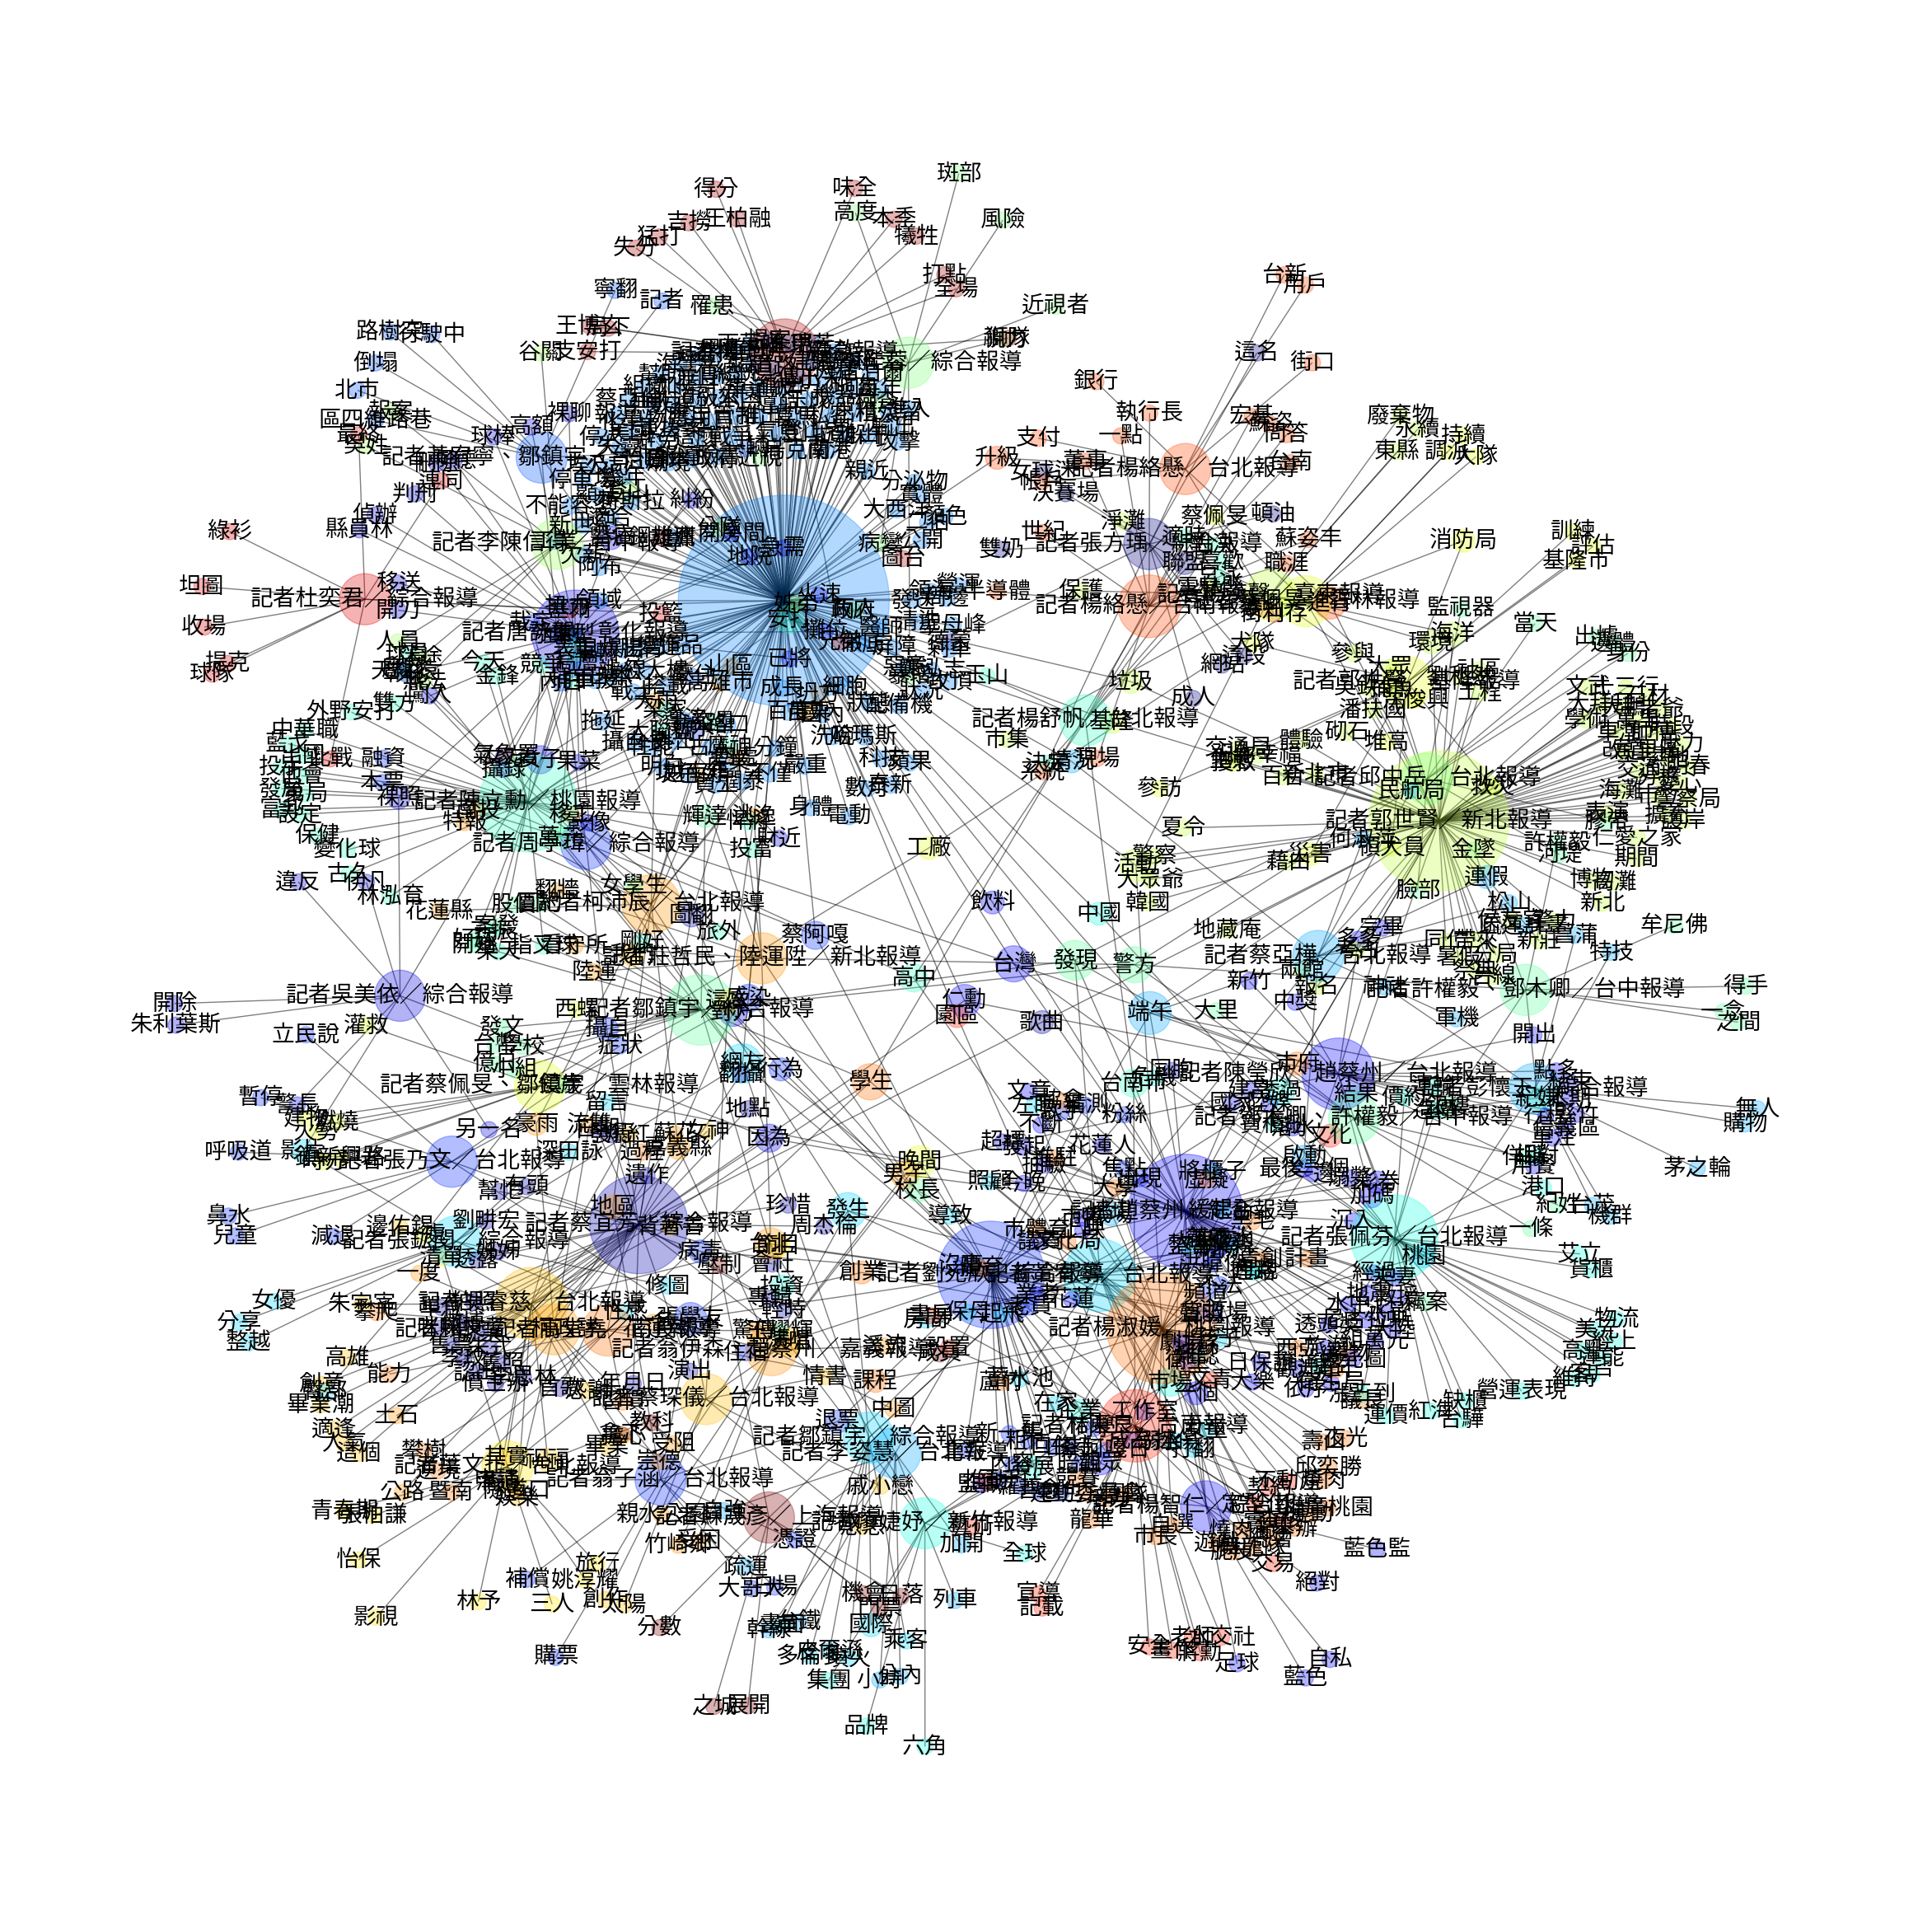

In [11]:
import jieba.analyse
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# 設置字體
fontManager.addfont(font_path)
mpl.rc('font', family='Taipei Sans TC Beta')

def keep_chinese_chars(text):
    pattern = re.compile(r'[^\u4e00-\u9fff]')
    chinese_text = re.sub(pattern, '', text)
    return chinese_text

def extract_keywords(text):
    text = keep_chinese_chars(text)
    return jieba.analyse.extract_tags(text, topK=10)

df_news['keywords'] = df_news['content'].apply(extract_keywords)

def draw(df):
    G = nx.Graph()

    for i, row in df.iterrows():
        author = row['author']
        keywords = row['keywords']

        G.add_node(author, type='author')

        for keyword in keywords:
            G.add_node(keyword, type='keyword')
            G.add_edge(author, keyword)

    partition = community_louvain.best_partition(G)
    community_colors = [partition[node] for node in G.nodes()]
    cmap = plt.cm.jet
    colors_with_alpha = [cmap(community_color / max(community_colors)) for community_color in community_colors]
    colors_with_alpha = [(r, g, b, 0.3) for r, g, b, _ in colors_with_alpha]
    node_sizes = [200 * G.degree(node) for node in G.nodes()]
    pos = nx.spring_layout(G, k=0.2, iterations=80)

    plt.figure(figsize=(30, 30))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_nodes(G, pos, node_color=colors_with_alpha, node_size=node_sizes, cmap=plt.cm.jet)
    nx.draw_networkx_labels(G, pos, font_size=20, font_family='Taipei Sans TC Beta')

    plt.axis('off')
    plt.show()

draw(df_news)
